# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

In [1]:
# load packages

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor


In [2]:
# import data

df = pd.read_csv('/datasets/taxi.csv', index_col = [0], parse_dates = [0])

We will start by getting some information on what our data looks like, checking for missing values, etc.

In [3]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


We first want to resample our data by the hour.

In [6]:
df = df.resample('1H').sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Analysis

To get an idea of how our data looks before performing analysis, we will do a few plots.

First, we will do a rolling mean. in order to smooth out or data, there are a variety of different possible numbers to set as our rolling average. To help us find out how we might wish to perform our rolling mean, we can start by doing a seasonal decomposition.

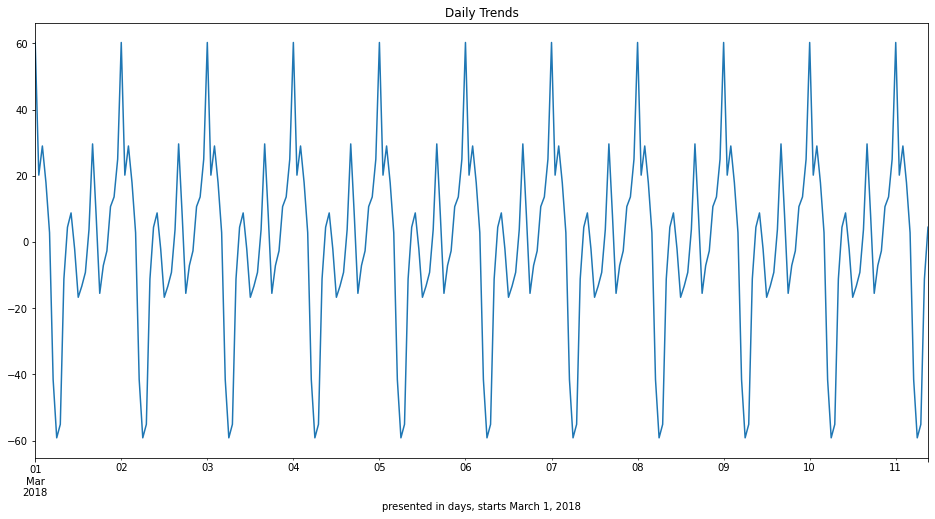

In [7]:
# daily trend graph

decomposed = seasonal_decompose(df)
decomposed.seasonal[0:250].plot(title = 'Daily Trends', xlabel = 'presented in days, starts March 1, 2018',
                                ax = plt.gca(), figsize = (16, 8));

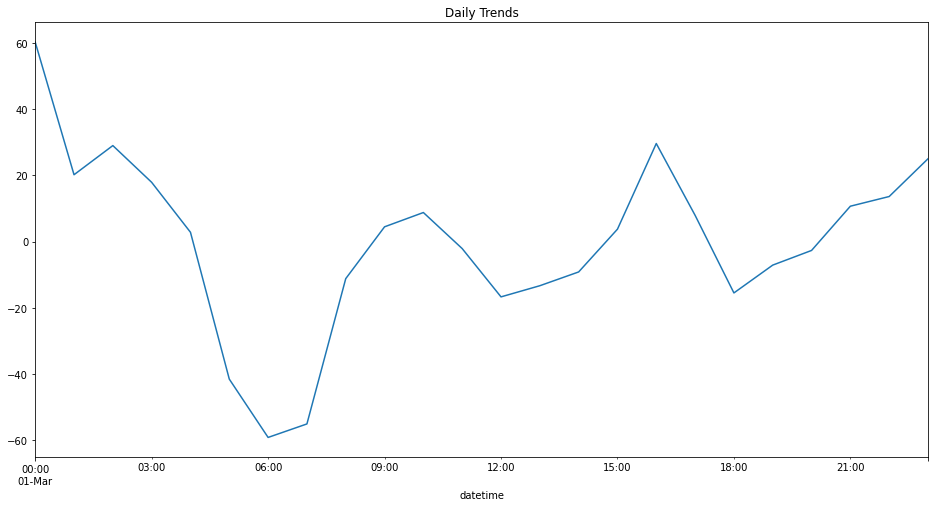

In [8]:
# daily trend graph zoomed in to a single day

decomposed.seasonal[0:24].plot(title = 'Daily Trends', ax = plt.gca(), figsize = (16, 8));

Here we can see that there are some fairly consistent trends on a day to day basis. Each day our trend lines switch from increasing to decreasing multiple times. We can describe our activity in four general patterns:

* 00:00 to 06:00

* 06:00 to 12:00

* 12:00 to 18:00

* 18:00 to 00:00

These four segments have a steep trend downward, then a quadratic trend with a peak at around 09:00 or 10:00, then a v-shaped pattern with a peak at around 16:00, and finally a steady trend upwards. Since these appear to be fairly consistent on a day to day basis, we can probably get a well suited rolling mean using a window size of 6.

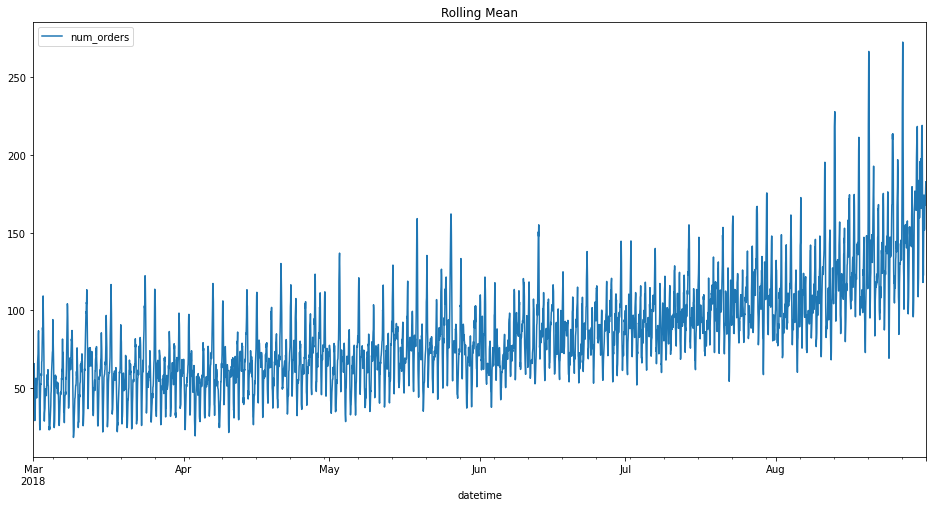

In [9]:
# rolling mean

df.rolling(6).mean().plot(title = 'Rolling Mean', figsize = (16, 8));

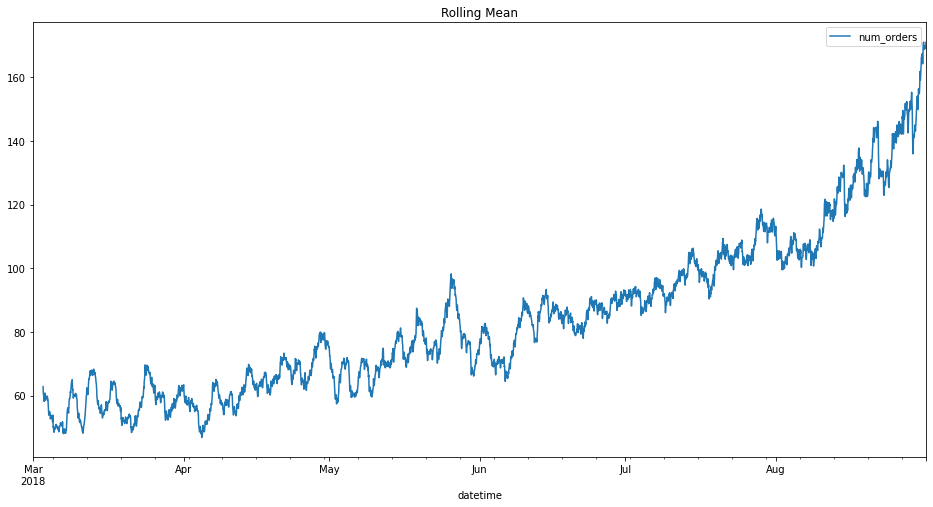

In [10]:
# a graph with a greater smoothing, might provide better insight into the general trend of our orders

df.rolling(50).mean().plot(title = 'Rolling Mean', figsize = (16, 8));

The rolling mean of our data shows promise. Our number of orders overall appears to be steadily increasing, and if the trend continues we appears that it might be growing more quickly in some of the recent months which could mean that the growth is speeding up or it could also be that our growth is simply becoming more unpredictable. However, it might also mean simply that we are seeing more people using our services in the Summer and we might begin to dip later in the year.

## Training

First, we will want to account for our features. We have a datetime column that we should split into new features. This will help us with model training and focus on peak hours.

When we make our features we will start taking a rolling mean after our first day of observations, so we will start at point 24.

In [11]:
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()


In [12]:
# run make_features on the data

make_features(df, 1, 24)

In [13]:
df.head(30)

,num_orders,hour,month,day,dayofweek,lag_1,rolling_mean
datetime,,,,,,,
2018-03-01 00:00:00,124,0,3,1,3,NaN,NaN
2018-03-01 01:00:00,85,1,3,1,3,124.0,NaN
2018-03-01 02:00:00,71,2,3,1,3,85.0,NaN
2018-03-01 03:00:00,66,3,3,1,3,71.0,NaN
2018-03-01 04:00:00,43,4,3,1,3,66.0,NaN
2018-03-01 05:00:00,6,5,3,1,3,43.0,NaN
2018-03-01 06:00:00,12,6,3,1,3,6.0,NaN
2018-03-01 07:00:00,15,7,3,1,3,12.0,NaN
2018-03-01 08:00:00,34,8,3,1,3,15.0,NaN


Before we split our data we should drop our first row since by design it has null values.

In [14]:
df.dropna(axis = 0, inplace = True)

Next we should split our data into training and test sets. The test size is set at 10% of the data set. We also should want a validation set, which we will set as being 10% of our training set or 9% of our overall data. To get the best model we will make our test and validation sets by taking the newest data by choosing not to shuffle our raw data.

In [15]:
# test set

train, test = train_test_split(df, shuffle = False, test_size = 0.1)

# validation set

train, valid = train_test_split(train, shuffle = False, test_size = 0.1)

In [16]:
# split into features and target

features_train = train.drop(['num_orders'], axis = 1)
target_train = train['num_orders']

features_valid = valid.drop(['num_orders'], axis = 1)
target_valid = valid['num_orders']

features_test = test.drop(['num_orders'], axis = 1)
target_test = test['num_orders']

In [17]:
# set our RMSE threshold (of 48)

threshold = 48

# create function to calculate rmse

def rmse(target, predictions): 
    rmse = mean_squared_error(target, predictions) ** 0.5
    if rmse > threshold:
        print("RMSE is", rmse, "which is above our threshold value of", threshold)
    return rmse

To get a good idea of how much parameter tuning we might need, we will start by analyzing a dummy prediction to get a baseline for what our RMSE will look like.

In [18]:
# test against a dummy model

pred_mean = np.ones(valid['num_orders'].shape) * valid['num_orders'].mean()
print("Dummy model RMSE:", rmse(valid['num_orders'], pred_mean))

Dummy model RMSE: 46.18653283672647


Luckily our dummy model's RMSE is already 46.1865. Technically speaking this would be "good enough" since the error is below our threshold but of course it follows that we should actually focus on making the best model we can. We will test five baseline models of regression - linear, random forest, catboost, LGBM and XGB regressions.

### Regression Checks

In [19]:
%%time

# linear regression

lin_reg = LinearRegression()

lin_reg.fit(features_train, target_train)

CPU times: user 2.76 ms, sys: 617 µs, total: 3.38 ms
Wall time: 2.82 ms


LinearRegression()

In [20]:
%%time

lr_pred = lin_reg.predict(features_valid)

CPU times: user 2.87 ms, sys: 664 µs, total: 3.54 ms
Wall time: 1.74 ms


In [21]:
rmse(target_valid, lr_pred)

41.001127356304806

In [22]:
%%time

# random forest

rf = RandomForestRegressor(random_state = 12345)

rf.fit(features_train, target_train)

CPU times: user 867 ms, sys: 27.2 ms, total: 894 ms
Wall time: 914 ms


RandomForestRegressor(random_state=12345)

In [23]:
%%time

rf_pred = rf.predict(features_valid)

CPU times: user 15.6 ms, sys: 1.01 ms, total: 16.6 ms
Wall time: 15.1 ms


In [24]:
rmse(target_valid, rf_pred)

33.20470886269846

In [25]:
%%time

# cat boost

cb = CatBoostRegressor(iterations = 500, random_state = 12345)

cb.fit(features_train, target_train, eval_set=(features_valid, target_valid))

Learning rate set to 0.094847
0:	learn: 34.4346285	test: 55.7967202	best: 55.7967202 (0)	total: 48.9ms	remaining: 24.4s
1:	learn: 33.0188435	test: 54.0617960	best: 54.0617960 (1)	total: 49.9ms	remaining: 12.4s
2:	learn: 31.8364452	test: 52.2756528	best: 52.2756528 (2)	total: 50.8ms	remaining: 8.42s
3:	learn: 30.9479801	test: 51.0684130	best: 51.0684130 (3)	total: 51.7ms	remaining: 6.41s
4:	learn: 29.9654271	test: 49.8714546	best: 49.8714546 (4)	total: 52.7ms	remaining: 5.21s
5:	learn: 29.1202675	test: 48.3758289	best: 48.3758289 (5)	total: 53.5ms	remaining: 4.41s
6:	learn: 28.3601610	test: 47.3623091	best: 47.3623091 (6)	total: 54.4ms	remaining: 3.83s
7:	learn: 27.9020918	test: 46.4620098	best: 46.4620098 (7)	total: 55.4ms	remaining: 3.4s
8:	learn: 27.3515889	test: 45.7241402	best: 45.7241402 (8)	total: 56.3ms	remaining: 3.07s
9:	learn: 26.9837408	test: 45.0090300	best: 45.0090300 (9)	total: 57.2ms	remaining: 2.8s
10:	learn: 26.5811486	test: 44.4513240	best: 44.4513240 (10)	total: 58.1

In [26]:
%%time

cb_pred = cb.predict(features_valid)

CPU times: user 2.48 ms, sys: 267 µs, total: 2.74 ms
Wall time: 1.49 ms


In [27]:
rmse(target_valid, cb_pred)

32.418476025902436

In [28]:
%%time

# lgbm

lgbm = LGBMRegressor(random_state = 12345)
lgbm.fit(features_train, target_train, eval_set=(features_valid, target_valid))

[1]	valid_0's l2: 3045.96
[2]	valid_0's l2: 2789.84
[3]	valid_0's l2: 2542.16
[4]	valid_0's l2: 2330.25
[5]	valid_0's l2: 2166.96
[6]	valid_0's l2: 2016.15
[7]	valid_0's l2: 1900.69
[8]	valid_0's l2: 1807.64
[9]	valid_0's l2: 1712.59
[10]	valid_0's l2: 1642.49
[11]	valid_0's l2: 1587.73
[12]	valid_0's l2: 1521.1
[13]	valid_0's l2: 1472.04
[14]	valid_0's l2: 1429.66
[15]	valid_0's l2: 1393.99
[16]	valid_0's l2: 1358.83
[17]	valid_0's l2: 1342.11
[18]	valid_0's l2: 1315.62
[19]	valid_0's l2: 1281.55
[20]	valid_0's l2: 1250.87
[21]	valid_0's l2: 1220.6
[22]	valid_0's l2: 1202.6
[23]	valid_0's l2: 1186.97
[24]	valid_0's l2: 1178.51
[25]	valid_0's l2: 1173.62
[26]	valid_0's l2: 1151.77
[27]	valid_0's l2: 1153.98
[28]	valid_0's l2: 1146.1
[29]	valid_0's l2: 1142.57
[30]	valid_0's l2: 1131.32
[31]	valid_0's l2: 1127.07
[32]	valid_0's l2: 1115.38
[33]	valid_0's l2: 1106.98
[34]	valid_0's l2: 1103.91
[35]	valid_0's l2: 1104.12
[36]	valid_0's l2: 1097.55
[37]	valid_0's l2: 1087.61
[38]	valid_0's

LGBMRegressor(random_state=12345)

In [29]:
%%time

lgbm_pred = lgbm.predict(features_valid)

CPU times: user 39.9 ms, sys: 982 µs, total: 40.9 ms
Wall time: 81.2 ms


In [30]:
rmse(target_valid, lgbm_pred)

32.32794542338714

In [31]:
%%time

# xgb

xgb = XGBRegressor(random_state = 12345)
xgb.fit(features_train, target_train)

CPU times: user 28.2 s, sys: 355 ms, total: 28.5 s
Wall time: 28.7 s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=12345,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [32]:
%%time

xgb_pred = xgb.predict(features_valid)

CPU times: user 38.7 ms, sys: 173 µs, total: 38.8 ms
Wall time: 51.8 ms


In [33]:
rmse(target_valid, xgb_pred)

35.399759720079736

From the looks of things, all of our regressions seem to have fairly comparable results. The linear regression appears to be less accurate but it might not be the case after tuning the hyperparameters. However, since we have already fulfilled our targeted accuracy and hyperparameter grid searching can be quite time consuming, we will focus on just LGBM, the most promising model.

### Hyperparameter Tuning


In [34]:
# create grid for hyperparamters

# lgbm

lgbm_params = {
    'boosting_type': ['gbdt', 'dart', 'goss'],
    'num_leaves' : [20, 30, 40, 50],
    'learning_rate' : [0.05, 0.1, 0.15, 0.25],
    'n_estimators': (100, 150, 200, 250)
}


In [35]:
%%time

lgbm_grid = GridSearchCV(estimator = lgbm, param_grid = lgbm_params, verbose = 3)
lgbm_grid.fit(features_train, target_train, eval_set=(features_valid, target_valid))

In [36]:
lgbm_grid.best_params_

In [37]:
lgbm_reg = LGBMRegressor(boosting_type = 'dart', learning_rate = 0.25, n_estimators = 100,
                         num_leaves = 20, random_state = 12345)

lgbm_reg.fit(features_train, target_train, eval_set=(features_valid, target_valid))

[1]	valid_0's l2: 2625.17
[2]	valid_0's l2: 2104.92
[3]	valid_0's l2: 1866.85
[4]	valid_0's l2: 1658.87
[5]	valid_0's l2: 1522.28
[6]	valid_0's l2: 1534.13
[7]	valid_0's l2: 1429.63
[8]	valid_0's l2: 1350.29
[9]	valid_0's l2: 1372.32
[10]	valid_0's l2: 1312.13
[11]	valid_0's l2: 1266.87
[12]	valid_0's l2: 1302.44
[13]	valid_0's l2: 1239.08
[14]	valid_0's l2: 1183.6
[15]	valid_0's l2: 1242.28
[16]	valid_0's l2: 1221.95
[17]	valid_0's l2: 1214.81
[18]	valid_0's l2: 1217.26
[19]	valid_0's l2: 2135.99
[20]	valid_0's l2: 1823.48
[21]	valid_0's l2: 1586.78
[22]	valid_0's l2: 1421.11
[23]	valid_0's l2: 1425.99
[24]	valid_0's l2: 1328.62
[25]	valid_0's l2: 1240.37
[26]	valid_0's l2: 1200.57
[27]	valid_0's l2: 1147.58
[28]	valid_0's l2: 1147.73
[29]	valid_0's l2: 1129.2
[30]	valid_0's l2: 1132.91
[31]	valid_0's l2: 1162.28
[32]	valid_0's l2: 1127.56
[33]	valid_0's l2: 1179.94
[34]	valid_0's l2: 1207.66
[35]	valid_0's l2: 1168.9
[36]	valid_0's l2: 1177.94
[37]	valid_0's l2: 1131.03
[38]	valid_0'

LGBMRegressor(boosting_type='dart', learning_rate=0.25, num_leaves=20,
              random_state=12345)

In [38]:
%%time

lgbm_pred = lgbm_reg.predict(features_valid)

CPU times: user 40.4 ms, sys: 187 µs, total: 40.5 ms
Wall time: 10.8 ms


In [39]:
rmse(target_valid, lgbm_pred)

32.69457636939533

Our model seems to be more accurate, but it does not appear to have gotten substantially so. Tuning the hyperparameters likely will lead to diminishing returns for accuracy in regards to time, and our RMSE still seems to be fine. We should proceed to the test set.

## Testing

In [40]:
%%time

lgbm_pred = lgbm_reg.predict(features_test)

CPU times: user 46.3 ms, sys: 0 ns, total: 46.3 ms
Wall time: 71.3 ms


In [41]:
rmse(target_test, lgbm_pred)

RMSE is 53.5998222124338 which is above our threshold value of 48


53.5998222124338

We see here that although our validation set matched fairly well that the RMSE against the test set is too high. This might suggest that the model is overfitted, but regardless of the reason it might not be an error that we want to solve by doing further tuning to the LGBM model. We can try to go through some alternate models and see if they might give more desirable results.

### Model improvements

We will start by trying out the random forest.

In [42]:
rf_params = {
    'n_estimators': (100, 150, 200),
    'min_samples_split' : (2, 5, 10, 15),
    'max_depth' : (1, 5, 10, 25, None)
}

In [43]:
%%time

rf_grid = GridSearchCV(estimator = rf, param_grid = rf_params, verbose=3)
rf_grid.fit(features_train, target_train)

In [44]:
rf_grid.best_params_

In [45]:
%%time

rf_reg = RandomForestRegressor(max_depth = 25, min_samples_split= 15, n_estimators = 200, random_state = 12345)

rf_reg.fit(features_train, target_train)

CPU times: user 1.27 s, sys: 0 ns, total: 1.27 s
Wall time: 1.3 s


RandomForestRegressor(max_depth=25, min_samples_split=15, n_estimators=200,
                      random_state=12345)

In [46]:
%%time

rf_pred = rf_reg.predict(features_test)

CPU times: user 22.7 ms, sys: 0 ns, total: 22.7 ms
Wall time: 21.3 ms


In [47]:
rmse(target_test, rf_pred)

45.47782947562207

### Other possible tuning checks

Tuning our random forest does provide us with RMSE that is within our requirements. We could either continue to improve on this model or consider our model sufficient here. To get a quick overview on which to choose, we could take another look at our baseline models predictions against the test set.

In [48]:
print("Baseline Test RMSEs:")
print()
print("Linear Regression:", rmse(target_test, lin_reg.predict(features_test)))
print()
print("Random Forest:", rmse(target_test, rf.predict(features_test)))
print()
print("Catboost:", rmse(target_test, cb.predict(features_test)))
print()
print("LGBM:", rmse(target_test, lgbm.predict(features_test)))
print()
print("XGB:", rmse(target_test, xgb.predict(features_test)))

Baseline Test RMSEs:

RMSE is 52.34782474509176 which is above our threshold value of 48
Linear Regression: 52.34782474509176

Random Forest: 46.4929030776839

RMSE is 53.79413184383542 which is above our threshold value of 48
Catboost: 53.79413184383542

RMSE is 52.62873295731337 which is above our threshold value of 48
LGBM: 52.62873295731337

RMSE is 55.67457861437892 which is above our threshold value of 48
XGB: 55.67457861437892


We see from testing our initial models without tuning any of our hyperparameters that random forest was best dealing with the test set. Since random forest tends to be well suited to not being overfit, this probably does suggest that our other models are overfitted. Since it is generally unclear how large of an effect hyperparameter fitting can have on model quality and our random forest model is working, it should be best to remain efficient and keep to using that random forest model.

## Conclusion

Within the project we have analyzed and cleaned our data, checked it graphically for trends and seasonality. We split our date and time into a number of separate features that would help build our model and then split into a training, validation and test sets with a test size of 10%.

We checked some initial regressions against the validation set and found that most baseline regressors seemed to possess comparable results so we chose to focus on the one with the best RMSE to use as our model to finetune the hyperparameters. However, when we checked our model against the test set we found that the RMSE was too high and so we tested against some of our other models.

The random forest proved to be sufficiently fitted to our goals and we double checked our baseline models against the test set we found that they all performed too poorly when checking against the test set even though they were all fine against the validation set, which may be the result of overfitting.

# Review checklist

- [x]  Jupyter Notebook is open
- [x]  The code is error-free
- [x]  The cells with the code have been arranged in order of execution
- [x]  The data has been downloaded and prepared
- [x]  The data has been analyzed
- [x]  The model has been trained and hyperparameters have been selected
- [x]  The models have been evaluated. Conclusion has been provided
- [x] *RMSE* for the test set is not more than 48